In [31]:
from zipfile import ZipFile
import os
import h5py
import numpy as np
import blimpy
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython import display
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.backends.backend_pgf import FigureCanvasPgf
%matplotlib inline

"""This ntbk combines the zip ntbk and the interactive plot zoom ntbks into one ntbk. The difference here is however 
one can type in a zip ntbk at the widget when running the program and the program will analyze it through the 
interact widget. There is a bug in the code as when interact is used, the display doesn't clear for some reason despite
the functions ALL having display.clear_output(wait = True) present. If you are able to fix this problem, it'd be much
appreciated."""

'This ntbk combines the zip ntbk and the interactive plot zoom ntbks into one ntbk. The difference here is however \none can type in a zip ntbk at the widget when running the program and the program will analyze it through the \ninteract widget.'

In [28]:
def read_zip_file(filepath):
    """
    Unzips a zip file given the filepath of the zip. If filepath is a zip and the function finds that the 
    unzipped version already exists, will return 'This file has already been unzipped'.
    """
    zip1title = filepath[0:-4]
    cwd = os.getcwd()
    pdir = os.path.abspath(os.path.join(os.getcwd(), '..'))
    if os.path.isdir(zip1title) == True:
        print('This file has already been unzipped.')
        nameList = [] 
        for file in os.listdir(zip1title):
            file = zip1title + '/' + file
            nameList.append(file)
        return(nameList)
    elif os.path.isfile(filepath) == False and filepath[-4:] == '.zip':
        print("The zipfile you entered isn't in the previous directory with respect to your current working directory: " + cwd)
        print("Please check that you've downloaded the file and move the zip file from the Downloads section (or wherever you saved it) to the parent directory: " + pdir)
    elif filepath[-4:] != '.zip':
        print("The file you entered is not a zipfile. Please enter a zipfile.")
    elif os.path.isfile(filepath) == True:
        zip1 = ZipFile(filepath)
        nameList = zip1.namelist()
        newNameList = []
        for name in nameList:
            name = '../' + name 
            newNameList.append(name)
        zip1.extractall('../')
        zip1.close()
        os.remove(filepath)
        return(newNameList)

def h5_header_wrapper(filename):
    """
    Gets header of a .h5 file.
    """
    h = h5py.File(filename)
    header = dict(h['data'].attrs.items())
    return header

def waterfallfunc(filepath):
    """
    Reads .h5 filepath into waterfall filterbank data
    """
    return(blimpy.Waterfall(filepath))

def waterfallTime(waterfall):
    """
    Returns the timestamps of the waterfall file's data
    """
    return(waterfall.populate_timestamps())

def waterfallFreqs(waterfall):
    """
    Returns the frequencies of the waterfall file's data
    """
    return(waterfall.populate_freqs())

def waterfallData(waterfall):
    """
    Extracts the actual data of the waterfall file
    """
    return(waterfall.data[:, 0, :])

def waterfallSize(waterfall):
    """
    Extracts the size of the data of the waterfall file
    """
    return(waterfall.data[:, 0, :].shape)

def elapsedTime(times):
    """
    Converting timestamps from MJD time into seconds elapsed since first observation
    """
    timesElapsedDays = times - times[0]
    timesElapsedSeconds = timesElapsedDays * 86400
    return(timesElapsedSeconds)

def locateTime(obsNumber, vertIndex, times):
    times1 = times[0]
    times2 = times[1]
    times3 = times[2]
    times4 = times[3]
    times5 = times[4]
    times6 = times[5]
    if obsNumber == 1:
        time = times1[vertIndex]
    elif obsNumber == 2:
        time = times2[vertIndex]
    elif obsNumber == 3:
        time = times3[vertIndex]
    elif obsNumber == 4:
        time = times4[vertIndex]
    elif obsNumber == 5:
        time = times5[vertIndex]
    elif obsNumber == 6:
        time = times6[vertIndex]
    return(time)

def locateFreq(obsNumber, horizIndex, freqs):
    freqs1 = freqs[0]
    freqs2 = freqs[1]
    freqs3 = freqs[2]
    freqs4 = freqs[3]
    freqs5 = freqs[4]
    freqs6 = freqs[5]
    if obsNumber == 1:
        freq = freqs1[horizIndex]
    elif obsNumber == 2:
        freq = freqs2[horizIndex]
    elif obsNumber == 3:
        freq = freqs3[horizIndex]
    elif obsNumber == 4:
        freq = freqs4[horizIndex]
    elif obsNumber == 5:
        freq = freqs5[horizIndex]
    elif obsNumber == 6:
        freq = freqs6[horizIndex]
    return(freq)

def reorganizingAllAsList(data, obsNumber, times, freqs):
    """
    Finding the time and freq for every data entry and putting them into a separate list. Input for function should
    be a waterfall data (refer to data list). horizDim corresponds to freq. vertDim corresponds to time.
    """
    plotTime = []
    plotFreqs = []
    dataAsList = []
    horizDim = data.shape[1]
    vertDim = data.shape[0]
    for i in range(vertDim):
        for j in range(horizDim):
            plotTime.append(locateTime(obsNumber, i, times))
            plotFreqs.append(locateFreq(obsNumber, j, freqs))
            dataAsList.append(data[i, j])
    return(plotFreqs, plotTime, dataAsList)

def reorganizingAllAsArray(data, obsNumber, times, freqs):
    """
    Finding the time and freq for every data entry and putting them into an array. Input for function should
    be a waterfall data (refer to data list). horizDim corresponds to freq. vertDim corresponds to time.
    """
    plotFreqs, plotTime, dataAsList = reorganizingAllAsList(data, obsNumber, times, freqs)
    horizDim = data.shape[1]
    vertDim = data.shape[0]
    dataAsArray = np.array(dataAsList).reshape(vertDim, horizDim)
    plotFreqsArray = np.array(plotFreqs).reshape(vertDim, horizDim)
    plotTimeArray = np.array(plotTime).reshape(vertDim, horizDim)
    return(plotFreqsArray, plotTimeArray, dataAsArray)

def ticksArray(data, obsNumber, times, freqs):
    """
    Finding the frequency ticks for an observation number's data and putting them into an array. 
    Input for function should be an observation number (1-6). horizDim corresponds to 
    freq. vertDim corresponds to time. The frequency ticks will be used for plotting the ticks
    on the x axis. 
    """
    freqsArray,_,_ = reorganizingAllAsArray(data, obsNumber, times, freqs)
    freqsLin = np.around(np.linspace(np.amin(freqsArray), np.amax(freqsArray), 6), 2)
    freqsLinTicks = np.around(np.linspace(freqsLin[1], freqsLin[-1], 4), 2)
    return(freqsLinTicks)

def readFiles(filepathZip):
    """
    Finds the titles list, data list, ticks arrays, and waterfall files of a given zip filepath
    """
    observationFilepaths = read_zip_file(filepathZip)
    filepaths = [observationFilepaths[0], observationFilepaths[1], observationFilepaths[2], observationFilepaths[3], observationFilepaths[4], observationFilepaths[5]]
    hd = [h5_header_wrapper(filepath) for filepath in filepaths]
    waterfalls = [waterfallfunc(filepath) for filepath in filepaths] 
    data = [waterfallData(waterfall) for waterfall in waterfalls]
    times = [waterfallTime(waterfall) for waterfall in waterfalls]
    freqs = [waterfallFreqs(waterfall) for waterfall in waterfalls]
    titles = [str(hd[0]['source_name']), str(hd[1]['source_name']), str(hd[2]['source_name']), str(hd[3]['source_name']), str(hd[4]['source_name']), str(hd[5]['source_name'])]
    titles = [titles[0][2:-1].upper(), titles[1][2:-1].upper(), titles[2][2:-1].upper(), titles[3][2:-1].upper(), titles[4][2:-1].upper(), titles[5][2:-1].upper()]
    ticks = []
    for i in range(0, len(data)):
        tick = ticksArray(data[i], i + 1, times, freqs)
        ticks.append(tick)
    return(titles, data, ticks, waterfalls)
        

In [29]:
def Plot6Plots(filepathZip, saveAs):
    """
    Plotting the 6 plots of the observation. saveAs has 3 options: png, pdf, None. 
    saveAs decides what file to save plots as. 
    """
    titles, data, ticks, waterfalls = readFiles(filepathZip)
    display.clear_output()
    plt.rc('text', usetex=True)
    plt.rc('font', size = 16, family='serif')
    plt.rc('axes', titlesize = 16, labelsize = 16)
    plt.rc('xtick', labelsize = 14)
    plt.rc('ytick', labelsize = 14)
    title1, title2, title3, title4, title5, title6 = titles[0], titles[1], titles[2], titles[3], titles[4], titles[5]
    ticks1, ticks2, ticks3, ticks4, ticks5, ticks6 = ticks[0], ticks[1], ticks[2], ticks[3], ticks[4], ticks[5]
    waterfall1, waterfall2, waterfall3, waterfall4, waterfall5, waterfall6 = waterfalls[0], waterfalls[1], waterfalls[2], waterfalls[3], waterfalls[4], waterfalls[5]
    fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (19, 10))
    axes1 = plt.subplot(231, title = title1, xticks = ticks1)
    waterfall1.plot_waterfall()
    axes1.set_title(title1)
    axes2 = plt.subplot(234, title = title2, xticks = ticks2)
    waterfall2.plot_waterfall()
    axes2.set_title(title2)
    axes3 = plt.subplot(232, title = title3, xticks = ticks3)
    waterfall3.plot_waterfall()
    axes3.set_title(title3)
    axes4 = plt.subplot(235, title = title4, xticks = ticks4)
    waterfall4.plot_waterfall()
    axes4.set_title(title4)
    axes5 = plt.subplot(233, title = title5, xticks = ticks5)
    waterfall5.plot_waterfall()
    axes5.set_title(title5)
    axes6 = plt.subplot(236, title = title6, xticks = ticks6)
    waterfall6.plot_waterfall()
    axes6.set_title(title6)
    plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
    fig.show()
    if saveAs.lower() == 'png':
        fig.savefig(titles[0] + '_6plots.png', dpi = 600)
    elif saveAs.lower() == 'pdf':
        fig.savefig(titles[0] + '_6plots.pdf')
    else:
        pass

def PlotWithOffObs(filepathZip, onObsNumber, saveAs):
    """
    Plotting the waterfall plots for the on observation chosen as well as the off observation. 
    onObsNumber, which refers to the on observation number, is 1, 3, or 5. Also, the argument saveAs \
    will decide what file to save the plots as. saveAs will have 3 options for input: pdf, png, None.
    """
    titles, data, ticks, waterfalls = readFiles(filepathZip)
    plt.rc('text', usetex=True)
    plt.rc('font', size = 16, family='serif')
    plt.rc('axes', titlesize = 16, labelsize = 16)
    plt.rc('xtick', labelsize = 15)
    plt.rc('ytick', labelsize = 15)
    waterfallOn, waterfallOff = waterfalls[onObsNumber - 1], waterfalls[onObsNumber]
    titleOn, titleOff = titles[onObsNumber - 1], titles[onObsNumber]
    display.clear_output(wait=True)
    fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (9, 14))
    """onObservation plot"""
    axes1 = plt.subplot(211, xticks = ticks[onObsNumber - 1], title = titleOn + " On Observation " + str(onObsNumber))
    waterfallOn.plot_waterfall()
    axes1.set_title(titleOn + " On Observation " + str(onObsNumber))
    """offObservation plot"""
    axes2 = plt.subplot(212, xticks = ticks[onObsNumber], title =  titleOff + ", Off Observation")
    waterfallOff.plot_waterfall()
    axes2.set_title(titleOff + ", Off Observation")
    fig.tight_layout()
    fig.show()
    if saveAs == 'pdf':
        fig.savefig(titles[0] + '_onObservation' + str(onObsNumber) + 'zoom.pdf')
    elif saveAs == 'png':
        fig.savefig(titles[0] + '_onObservation' + str(onObsNumber) + 'zoom.png', dpi = 600)
    else:
        pass
        
def PlotWithZoom(filepathZip, onObsNumber, freqstart, freqend, tstart, tend, saveAs):
    """
    Plotting the waterfall plots for the on observation chosen as well as the off observation. 
    onObsNumber are 1, 3, or 5. Freqstart, freqend, tstart, tend decide which section of the graph will be zoomed in on.
    The output will be 4 plots. The 2 plots in the first column will be the on and off waterfall plots
    while the 2 plots in the second column will the zoomed in sections of both.
    saveAs will have 3 options for input: pdf, png, None.
    """
    titles, data, ticks, waterfalls = readFiles(filepathZip)
    display.clear_output()
    plt.rc('text', usetex=True)
    plt.rc('font', size = 16, family='serif')
    plt.rc('axes', titlesize = 16, labelsize = 16)
    plt.rc('xtick', labelsize = 15)
    plt.rc('ytick', labelsize = 15)
    display.clear_output(wait=True)
    titleOn, titleOff = titles[onObsNumber - 1], titles[onObsNumber]
    display.clear_output(wait=True)
    fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (14, 11))
    waterfallOn, waterfallOff = waterfalls[onObsNumber - 1], waterfalls[onObsNumber]
    """onObservation plot"""
    axes1 = plt.subplot(221, xticks = ticks[onObsNumber - 1], title = str(titleOn + " On Observation " + str(onObsNumber)))
    waterfallOn.plot_waterfall()
    axes1.set_title(str(titleOn + " On Observation " + str(onObsNumber)))
    """Zooming in for on"""
    axesOnObs = zoomed_inset_axes(axes1, 3, loc=1)
    waterfallOn.plot_waterfall(cb = False)
    axesOnObs.set_xlim(float(freqstart), float(freqend)) # apply the x-limits
    axesOnObs.set_ylim(float(tstart), float(tend)) # apply the y-limits
    plt.yticks(visible=False)
    plt.xticks(visible=False)
    plt.xlabel('', visible=False)
    plt.ylabel('', visible=False)
    plt.title('', visible=False)
    mark_inset(axes1, axesOnObs, loc1=1, loc2=2, fc="none", ec="r")
    axes1zoom = plt.subplot(222)
    waterfallOn.plot_waterfall()
    axes1zoom.set_xticks(np.linspace(float(freqstart), float(freqend), 5, endpoint = True))
    axes1zoom.set_xlim([float(freqstart), float(freqend)])
    axes1zoom.set_ylim([float(tstart), float(tend)])
    axes1zoom.set_xlabel('Frequency [MHz]')
    axes1zoom.set_ylabel('Time [s]')
    axes1zoom.set_title("On Observation Zoomed In")
    """offObservation plot"""
    axes2 = plt.subplot(223, xticks = ticks[onObsNumber], title = titleOff + ", Off Observation")
    waterfallOff.plot_waterfall()
    axes2.set_title(titleOff + ", Off Observation")
    """Zooming in for off"""
    axesOffObs = zoomed_inset_axes(axes2, 3, loc=1)
    waterfallOff.plot_waterfall(cb = False)
    axesOffObs.set_xlim(float(freqstart), float(freqend))
    axesOffObs.set_ylim(float(tstart), float(tend)) 
    plt.yticks(visible=False)
    plt.xticks(visible=False)
    plt.xlabel('', visible=False)
    plt.ylabel('', visible=False)
    plt.title('', visible=False)
    mark_inset(axes2, axesOffObs, loc1=1, loc2=2, fc="none", ec="r")
    axes2zoom = plt.subplot(224)
    waterfallOff.plot_waterfall()
    axes2zoom.set_xticks(np.linspace(float(freqstart), float(freqend), 5, endpoint = True))
    axes2zoom.set_xlim([float(freqstart), float(freqend)])
    axes2zoom.set_ylim([float(tstart), float(tend)])
    axes2zoom.set_xlabel('Frequency [MHz]')
    axes2zoom.set_ylabel('Time [s]')
    axes2zoom.set_title("Off Observation Zoomed In")
    fig.tight_layout()
    fig.show()
    if saveAs == 'pdf':
        fig.savefig(titles[0] + '_onObservation' + str(onObsNumber) + 'zoom.pdf')
    elif saveAs == 'png':
        fig.savefig(titles[0] + '_onObservation' + str(onObsNumber) + 'zoom.png', dpi = 600)
    else:
        pass

interactive(children=(Text(value='', description='filepathZip'), Dropdown(description='saveAs', options=('None…

<function __main__.Plot6Plots(filepathZip, saveAs)>

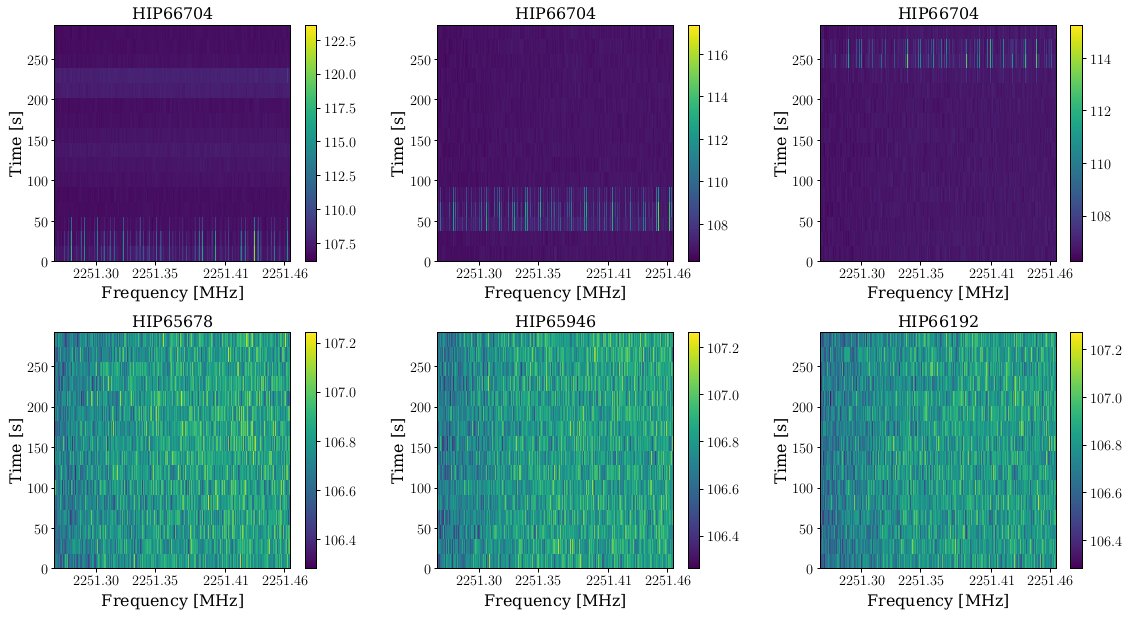

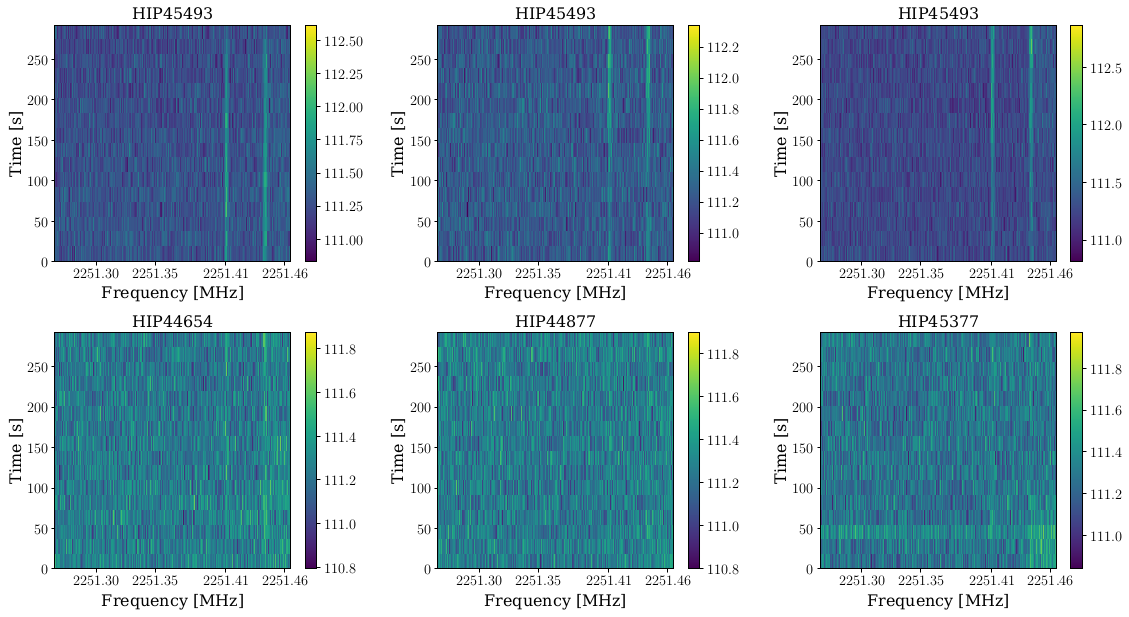

In [30]:
interact(Plot6Plots, filepathZip = '', saveAs = ['None', 'png', 'pdf'])

interactive(children=(Text(value='', description='filepathZip'), IntSlider(value=3, description='onObsNumber',…

<function __main__.PlotWithOffObs(filepathZip, onObsNumber, saveAs)>

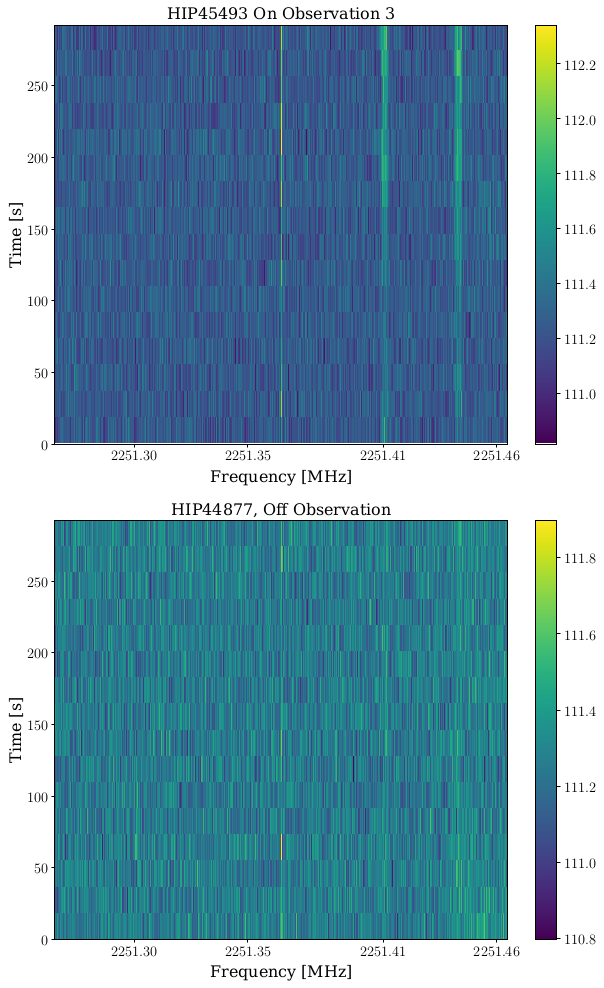

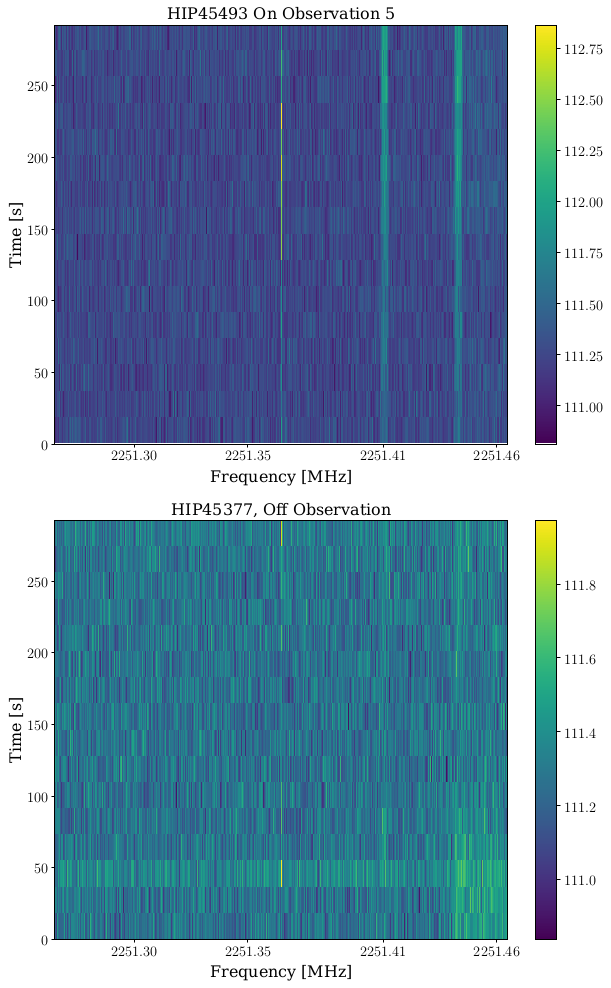

In [9]:
interact(PlotWithOffObs, filepathZip = '', onObsNumber = (1, 5, 2), saveAs = ['None', 'png', 'pdf'])

In [50]:
interact(PlotWithZoom, filepathZip = '', onObsNumber = (1, 5, 2), freqstart = '2251.30', freqend = '2251.33', tstart = '0', tend = '20', saveAs = ['None', 'png', 'pdf'])

interactive(children=(Text(value='', description='filepathZip'), IntSlider(value=3, description='onObsNumber',…

<function __main__.PlotWithZoom(filepathZip, onObsNumber, freqstart, freqend, tstart, tend, saveAs)>